# **PHISHGUARD: A Comprehensive Framework for Phishing Website Detection Using Machine Learning and Ensemble Models**

# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from catboost import CatBoostClassifier

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Filter warnings
warnings.filterwarnings('ignore')

## Dataset 05

The dataset is borrowed from [Kaggle, https://www.kaggle.com/eswarchandt/phishing-website-detector .](https://archive.ics.uci.edu/dataset/327/phishing+websites)

A collection of website URLs for 11000+ websites. Each sample has 30 website parameters and a class label identifying it as a phishing website or not (1 or -1).


- samples: 11055
- features: 30

In [2]:
# #Loading data into dataframe

# file_path = 'data/dataset5.csv'
# data1 = pd.read_csv(file_path)

# Loading data into dataframe, skipping problematic lines
file_path = 'data/dataset5.csv'
data1 = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')


In [3]:
data1.head()

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,10000000,1.0,0.0,18.0,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,10000000,0.0,0.0,11.0,150.636364,152.272727,0.0,0.0,0.0,0.0,0,0.768577,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,10000000,0.0,0.0,14.0,73.500000,72.642857,0.0,0.0,0.0,0.0,0,0.726582,1.0
3,mail.printakid.com/www.online.americanexpress....,10000000,0.0,0.0,6.0,562.000000,590.666667,0.0,0.0,0.0,0.0,0,0.85964,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,10000000,0.0,0.0,8.0,29.000000,24.125000,0.0,0.0,0.0,0.0,0,0.748971,1.0


In [4]:
data1.shape

(96005, 14)

In [5]:
list(data1.columns)

['domain',
 'ranking',
 'mld_res',
 'mld.ps_res',
 'card_rem',
 'ratio_Rrem',
 'ratio_Arem',
 'jaccard_RR',
 'jaccard_RA',
 'jaccard_AR',
 'jaccard_AA',
 'jaccard_ARrd',
 'jaccard_ARrem',
 'label']

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96005 entries, 0 to 96004
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   domain         96005 non-null  object 
 1   ranking        95953 non-null  object 
 2   mld_res        95935 non-null  object 
 3   mld.ps_res     95924 non-null  object 
 4   card_rem       95923 non-null  float64
 5   ratio_Rrem     95923 non-null  float64
 6   ratio_Arem     95923 non-null  float64
 7   jaccard_RR     95922 non-null  float64
 8   jaccard_RA     95921 non-null  float64
 9   jaccard_AR     95920 non-null  float64
 10  jaccard_AA     95919 non-null  float64
 11  jaccard_ARrd   95919 non-null  object 
 12  jaccard_ARrem  95917 non-null  object 
 13  label          95913 non-null  float64
dtypes: float64(8), object(6)
memory usage: 10.3+ MB


In [7]:
data1['ranking'] = pd.to_numeric(data1['ranking'], errors='coerce')  # Converts to numeric, invalid parsing will be set as NaN
data1['mld_res'] = pd.to_numeric(data1['mld_res'], errors='coerce')  # Converts to numeric, invalid parsing will be set as NaN
data1['mld.ps_res'] = pd.to_numeric(data1['mld.ps_res'], errors='coerce')  # Converts to numeric, invalid parsing will be set as NaN
data1['jaccard_ARrd'] = pd.to_numeric(data1['jaccard_ARrd'], errors='coerce')  # Converts to numeric, invalid parsing will be set as NaN
data1['jaccard_ARrem'] = pd.to_numeric(data1['jaccard_ARrem'], errors='coerce')  # Converts to numeric, invalid parsing will be set as NaN

In [8]:
# nunique value in columns

data1.nunique()

domain           96003
ranking           6985
mld_res              6
mld.ps_res           6
card_rem            53
ratio_Rrem       10042
ratio_Arem       10231
jaccard_RR        5446
jaccard_RA        5628
jaccard_AR        5071
jaccard_AA        5313
jaccard_ARrd       706
jaccard_ARrem    26083
label                2
dtype: int64

In [9]:
# We can see that there are no missing values in the Dataset
for col in data1.columns:
    unique_value_list = data1[col].unique()
    if len(unique_value_list) > 10:
        print(f'{col} has {data1[col].nunique()} unique values')
    else:
        print(f'{col} contains:\t\t\t{unique_value_list}')

domain has 96003 unique values
ranking has 6985 unique values
mld_res contains:			[1.00e+00 0.00e+00      nan 1.78e+02 1.00e+07 9.00e+00 1.10e+01]
mld.ps_res contains:			[  0.         1.        11.              nan 189.         7.
 148.818182]
card_rem has 53 unique values
ratio_Rrem has 10042 unique values
ratio_Arem has 10231 unique values
jaccard_RR has 5446 unique values
jaccard_RA has 5628 unique values
jaccard_AR has 5071 unique values
jaccard_AA has 5313 unique values
jaccard_ARrd has 706 unique values
jaccard_ARrem has 26083 unique values
label contains:			[ 1. nan  0.]


In [10]:
# Remove rows with NaN values in the 'label' column
data1 = data1.dropna(subset=['label'])

# Convert 'mld_res' and 'mld.ps_res' columns to numeric (forcing invalid values to NaN)
data1['mld_res'] = pd.to_numeric(data1['mld_res'], errors='coerce')
data1['mld.ps_res'] = pd.to_numeric(data1['mld.ps_res'], errors='coerce')

# Impute 'mld_res' column with the median value
data1['mld_res'].fillna(data1['mld_res'].median(), inplace=True)

# Impute 'mld.ps_res' column with the mean value
data1['mld.ps_res'].fillna(data1['mld.ps_res'].mean(), inplace=True)

# List of other numeric columns to fill with median values
numeric_cols = ['ranking', 'card_rem', 'ratio_Rrem', 'ratio_Arem', 'jaccard_RR', 'jaccard_RA', 'jaccard_AR', 'jaccard_AA']

# Convert the numeric columns to numeric (forcing invalid values to NaN)
for col in numeric_cols:
    data1[col] = pd.to_numeric(data1[col], errors='coerce')

# Loop through each column and fill NaN values with the median of that column
for col in numeric_cols:
    data1[col].fillna(data1[col].median(), inplace=True)

# Check if there are any remaining missing values
print(data1.isnull().sum())

domain           0
ranking          0
mld_res          0
mld.ps_res       0
card_rem         0
ratio_Rrem       0
ratio_Arem       0
jaccard_RR       0
jaccard_RA       0
jaccard_AR       0
jaccard_AA       0
jaccard_ARrd     0
jaccard_ARrem    0
label            0
dtype: int64


In [11]:
# We can see that there are no missing values in the Dataset
for col in data1.columns:
    unique_value_list = data1[col].unique()
    if len(unique_value_list) > 10:
        print(f'{col} has {data1[col].nunique()} unique values')
    else:
        print(f'{col} contains:\t\t\t{unique_value_list}')

domain has 95911 unique values
ranking has 6983 unique values
mld_res contains:			[1. 0.]
mld.ps_res contains:			[0. 1.]
card_rem has 49 unique values
ratio_Rrem has 10040 unique values
ratio_Arem has 10230 unique values
jaccard_RR has 5444 unique values
jaccard_RA has 5625 unique values
jaccard_AR has 5071 unique values
jaccard_AA has 5311 unique values
jaccard_ARrd has 704 unique values
jaccard_ARrem has 26082 unique values
label contains:			[1. 0.]


In [12]:
data1.shape

(95913, 14)

In [13]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95913 entries, 0 to 96004
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   domain         95913 non-null  object 
 1   ranking        95913 non-null  float64
 2   mld_res        95913 non-null  float64
 3   mld.ps_res     95913 non-null  float64
 4   card_rem       95913 non-null  float64
 5   ratio_Rrem     95913 non-null  float64
 6   ratio_Arem     95913 non-null  float64
 7   jaccard_RR     95913 non-null  float64
 8   jaccard_RA     95913 non-null  float64
 9   jaccard_AR     95913 non-null  float64
 10  jaccard_AA     95913 non-null  float64
 11  jaccard_ARrd   95913 non-null  float64
 12  jaccard_ARrem  95913 non-null  float64
 13  label          95913 non-null  float64
dtypes: float64(13), object(1)
memory usage: 11.0+ MB


In [14]:
# Let us drop the index column because that acts as a primary key and has no significance in EDA and modelling
data1 = data1.drop(data1.columns[0],axis=1)
data1

,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,10000000.0,1.0,0.0,18.0,107.611111,107.277778,0.000000,0.000000,0.000000,0.000000,0.800000,0.795729,1.0
1,10000000.0,0.0,0.0,11.0,150.636364,152.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.768577,1.0
2,10000000.0,0.0,0.0,14.0,73.500000,72.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.726582,1.0
3,10000000.0,0.0,0.0,6.0,562.000000,590.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.859640,1.0
4,10000000.0,0.0,0.0,8.0,29.000000,24.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.748971,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96000,339.0,1.0,1.0,2.0,142.500000,141.000000,0.009009,0.009091,0.006536,0.006601,0.450980,0.846906,0.0
96001,63029.0,1.0,0.0,3.0,114.000000,128.333333,0.002899,0.002577,0.002907,0.002584,0.750000,0.714623,0.0
96002,753.0,1.0,1.0,3.0,91.000000,101.333333,0.000000,0.003106,0.000000,0.000000,0.111111,0.648571,0.0
96003,6.0,1.0,1.0,4.0,682.000000,744.250000,0.033075,0.029412,0.030250,0.029145,0.809735,0.840323,0.0


In [15]:
#description of dataset

data1.describe().T

,count,mean,std,min,25%,50%,75%,max
ranking,95913.0,5.888826e+06,4.878397e+06,1.0,25475.000000,1.000000e+07,1.000000e+07,1.000000e+07
mld_res,95913.0,4.556004e-01,4.980274e-01,0.0,0.000000,0.000000e+00,1.000000e+00,1.000000e+00
mld.ps_res,95913.0,2.024543e-01,4.018311e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
card_rem,95913.0,4.573947e+00,4.343249e+00,0.0,2.000000,3.000000e+00,6.000000e+00,5.800000e+01
ratio_Rrem,95913.0,1.352637e+02,1.609930e+02,0.0,43.000000,1.040769e+02,1.741429e+02,5.507000e+03
ratio_Arem,95913.0,1.385556e+02,1.754849e+02,0.0,39.666667,1.033333e+02,1.783333e+02,6.097000e+03
jaccard_RR,95913.0,4.010518e-03,2.874704e-02,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
jaccard_RA,95913.0,3.768871e-03,2.447841e-02,0.0,0.000000,0.000000e+00,0.000000e+00,9.166670e-01
jaccard_AR,95913.0,3.367691e-03,2.379475e-02,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
jaccard_AA,95913.0,3.644641e-03,2.825969e-02,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


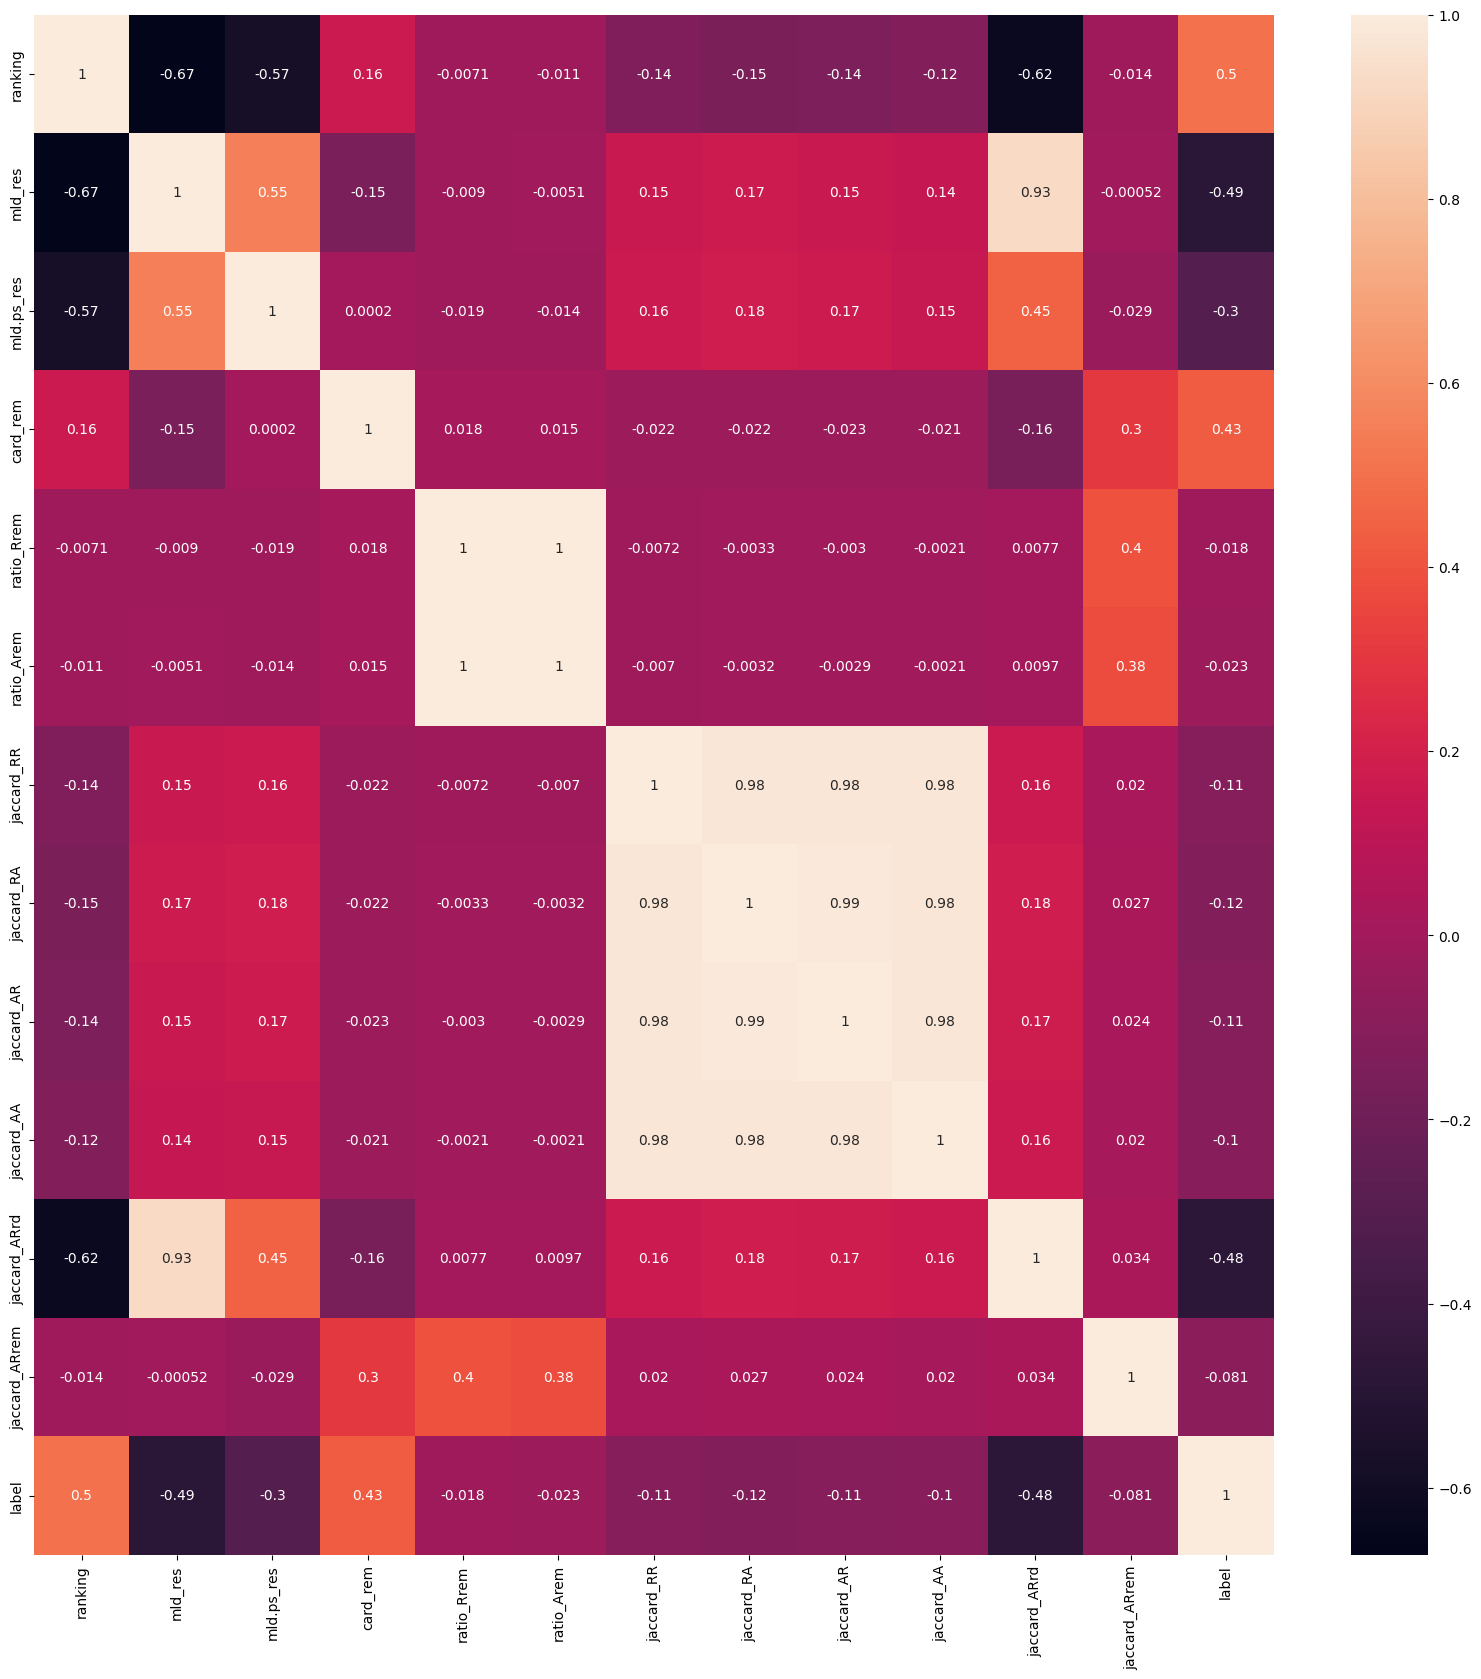

In [16]:
#Correlation heatmap

plt.figure(figsize=(20,20))
sns.heatmap(data1.corr(), annot=True)
plt.show()

### Distribution of Phishing and Legitimate Sites in Dataset

label
0.0    48009
1.0    47904
Name: count, dtype: int64


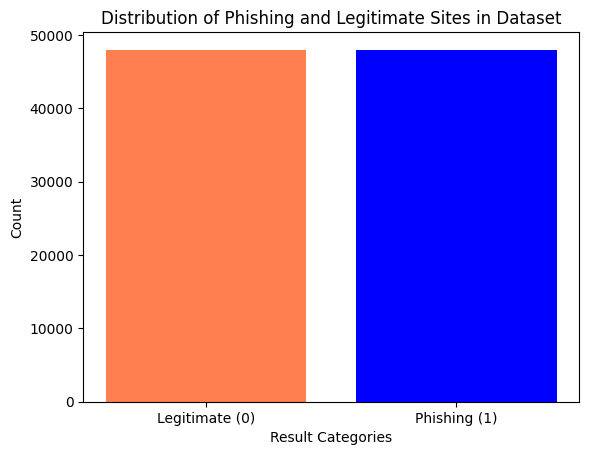

In [17]:
# Count the occurrences of each category in the 'Result' column
result_counts = data1['label'].value_counts()
print(data1['label'].value_counts())
# Defining colors for the bar chart based on the index of result_counts
# (assuming -1 for Phishing and 1 for Legitimate)
colors = ['Coral' if index == 0 else 'blue' for index in result_counts.index]

# Define labels for the categories
labels = ['Legitimate (0)','Phishing (1)']

# Create an enhanced bar chart
plt.bar(labels, result_counts.values, color=colors)
plt.xlabel('Result Categories')
plt.ylabel('Count')
plt.title('Distribution of Phishing and Legitimate Sites in Dataset')
plt.show()

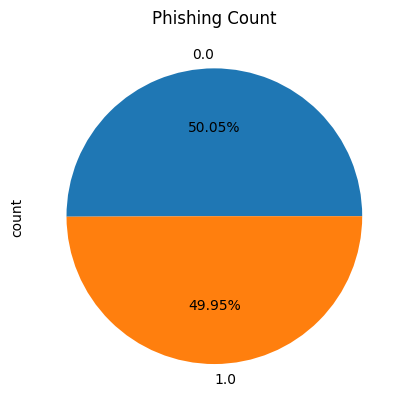

In [18]:
# Phishing Count in pie chart

data1['label'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title("Phishing Count")
plt.show()

The data seems pretty much balanced i.e. There is not a significant difference between the count of the target variable values.

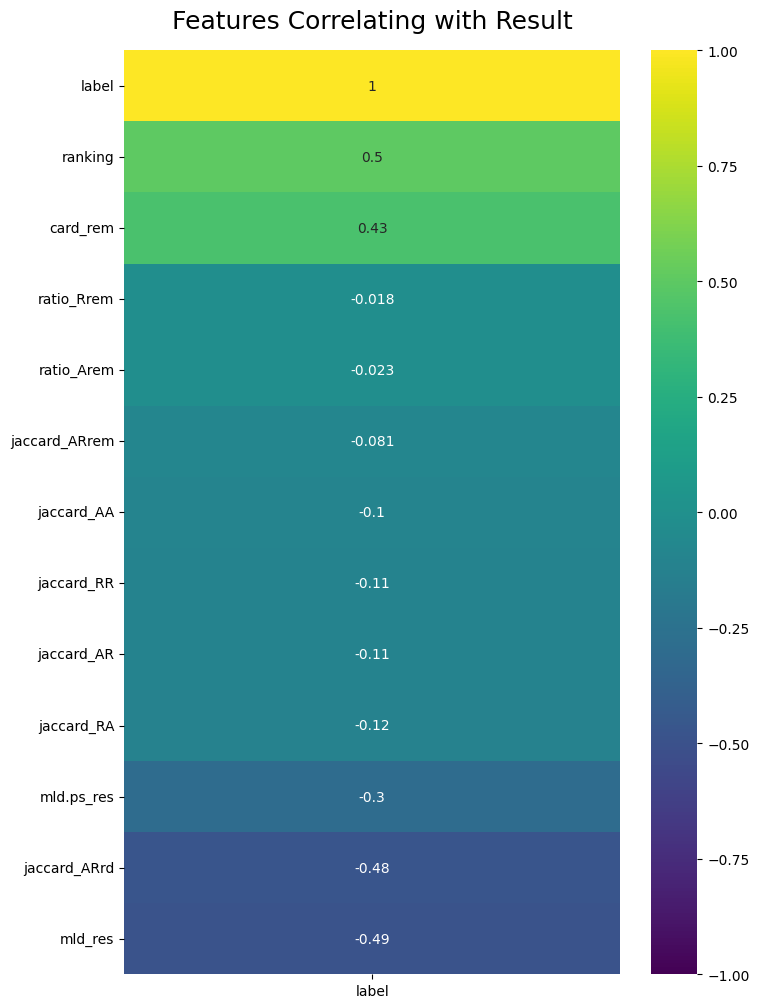

In [19]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(data1.corr()[['label']].sort_values(by='label', ascending=False), vmin=-1, vmax=1, annot=True, cmap = 'viridis')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapfeaturecorr.png', dpi=300, bbox_inches='tight')

In [20]:
# Creating holders to store the model performance results
ML_Model = []
ML_Config = []
accuracy = []
f1_score = []
recall = []
precision = []
auc_roc = []  # Adding a holder for AUC-ROC

# Function to call for storing the results
def storeResults(model,config, a, b, c, d, e):
    ML_Model.append(model)
    ML_Config.append(config)
    accuracy.append(round(a, 6))
    f1_score.append(round(b, 6))
    recall.append(round(c, 6))
    precision.append(round(d, 6))
    auc_roc.append(round(e, 6))

In [21]:
# Assuming X and y are your features and labels
X = data1.drop(["label"], axis=1)
y = data1["label"]

# Step 1: Split the dataset into training and test sets (before any preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Normalize the data
print("\n=== Normalizing the Data ===")
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Configuration to store the normalized data (for future use in multiple models)
configurations = [('Normalized Data', X_train_normalized, X_test_normalized, y_train)]


=== Normalizing the Data ===


---

# Support Vector Machine Classifier



In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd

# Step 3: Run SVM with Hyperparameter Tuning on normalized data
print("\n=== SVM Model Performance with Hyperparameter Tuning ===")

# # Defining an expanded parameter grid for hyperparameter tuning
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Different C values for regularization
#     'gamma': [1, 0.1, 0.01, 0.001],  # Explore a wider range of gamma values
#     'kernel': ['rbf']  # Include additional kernels for non-linear classification
# }
# Defining an expanded parameter grid for hyperparameter tuning
param_grid = {
    'C': [10],  # Different C values for regularization
    'gamma': [0.1],  # Explore a wider range of gamma values
    'kernel': ['rbf']  # Include additional kernels for non-linear classification
}
# GridSearchCV to find the best parameters for the SVC model
svc = GridSearchCV(SVC(probability=True), param_grid, cv=5)  # Set probability=True for AUC-ROC calculation

# Fitting the model for grid search with the training data
svc.fit(X_train_normalized, y_train)

# Predicting the target values for the training and test sets
y_train_svc = svc.predict(X_train_normalized)
y_test_svc = svc.predict(X_test_normalized)

# Computing the probability scores for AUC-ROC (for the positive class)
y_train_svc_proba = svc.predict_proba(X_train_normalized)[:, 1]  # Probability scores for the positive class
y_test_svc_proba = svc.predict_proba(X_test_normalized)[:, 1]

# Computing the metrics for the Support Vector Machine model
metrics_dict = {
    "Dataset": ["Training", "Test"],
    "Accuracy": [
        metrics.accuracy_score(y_train, y_train_svc),
        metrics.accuracy_score(y_test, y_test_svc),
    ],
    "F1 Score": [
        metrics.f1_score(y_train, y_train_svc),
        metrics.f1_score(y_test, y_test_svc),
    ],
    "Recall": [
        metrics.recall_score(y_train, y_train_svc),
        metrics.recall_score(y_test, y_test_svc),
    ],
    "Precision": [
        metrics.precision_score(y_train, y_train_svc),
        metrics.precision_score(y_test, y_test_svc),
    ],
    "AUC-ROC": [
        metrics.roc_auc_score(y_train, y_train_svc_proba),
        metrics.roc_auc_score(y_test, y_test_svc_proba),
    ]
}

# Converting the metrics into a pandas DataFrame for better display
df_metrics = pd.DataFrame(metrics_dict)

# Display the metrics DataFrame
print("\nSupport Vector Machine Model Performance Metrics")
print(df_metrics.to_string(index=False))

# Print the best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(svc.best_params_)



=== SVM Model Performance with Hyperparameter Tuning ===

Support Vector Machine Model Performance Metrics
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.817842  0.821355 0.838930   0.804502 0.906885
    Test  0.816504  0.820353 0.836839   0.804505 0.906160
Best hyperparameters found by GridSearchCV:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


# Random Forest Classifier


In [26]:
# Step 3: Run RandomForestClassifier with Hyperparameter Tuning on normalized data
print("\n=== Random Forest Model Performance with Hyperparameter Tuning ===")

# Defining an expanded parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200,300,400],
    'max_depth': [40,50,60],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['log2'],
    'bootstrap': [False],
    'criterion': ['gini']
}

# Using the normalized data directly from Part 1
X_train_cfg = X_train_normalized
X_test_cfg = X_test_normalized
y_train_cfg = y_train

# GridSearchCV to find the best parameters for the RandomForestClassifier
rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)  # 5-fold cross-validation

# Fitting the model for grid search with the training data
rf.fit(X_train_cfg, y_train_cfg)

# Predicting the target values for the training and test sets
y_train_rf = rf.predict(X_train_cfg)
y_test_rf = rf.predict(X_test_cfg)

# Computing the probability scores for AUC-ROC (for the positive class)
y_train_rf_proba = rf.predict_proba(X_train_cfg)[:, 1]  # Probability scores for the positive class
y_test_rf_proba = rf.predict_proba(X_test_cfg)[:, 1]

# Computing the metrics for the Random Forest model
metrics_dict = {
    "Dataset": ["Training", "Test"],
    "Accuracy": [
        metrics.accuracy_score(y_train_cfg, y_train_rf),
        metrics.accuracy_score(y_test, y_test_rf),
    ],
    "F1 Score": [
        metrics.f1_score(y_train_cfg, y_train_rf),
        metrics.f1_score(y_test, y_test_rf),
    ],
    "Recall": [
        metrics.recall_score(y_train_cfg, y_train_rf),
        metrics.recall_score(y_test, y_test_rf),
    ],
    "Precision": [
        metrics.precision_score(y_train_cfg, y_train_rf),
        metrics.precision_score(y_test, y_test_rf),
    ],
    "AUC-ROC": [
        metrics.roc_auc_score(y_train_cfg, y_train_rf_proba),
        metrics.roc_auc_score(y_test, y_test_rf_proba),
    ]
}

# Converting the metrics into a pandas DataFrame for better display
df_metrics = pd.DataFrame(metrics_dict)

# Display the metrics DataFrame
print("\nRandom Forest Model Performance Metrics")
print(df_metrics.to_string(index=False))

# Storing the results, now including the AUC-ROC score
storeResults('Random Forest',
             'Normalized Data',  # Using the normalized data configuration name
             metrics.accuracy_score(y_test, y_test_rf),
             metrics.f1_score(y_test, y_test_rf),
             metrics.recall_score(y_test, y_test_rf),
             metrics.precision_score(y_test, y_test_rf),
             metrics.roc_auc_score(y_test, y_test_rf_proba))

# Print the best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(rf.best_params_)

# Gradient Boosting Classifier

In [25]:
# Step 3: Run GradientBoostingClassifier with Hyperparameter Tuning
print("\n=== Gradient Boosting Model Performance with Hyperparameter Tuning ===")

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [400],
    'max_depth': [7,8]
}

# No need for configurations in this case since we're using normalized data from Part 1
X_train_cfg = X_train_normalized
X_test_cfg = X_test_normalized
y_train_cfg = y_train

# GridSearchCV to find the best parameters for the GradientBoostingClassifier
gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)

# Fitting the model for grid search with the training data
gbc.fit(X_train_cfg, y_train_cfg)

# Predicting the target values for the training and test sets
y_train_gbc = gbc.predict(X_train_cfg)
y_test_gbc = gbc.predict(X_test_cfg)

# Computing the probability scores for AUC-ROC (for the positive class)
y_train_gbc_proba = gbc.predict_proba(X_train_cfg)[:, 1]  # Probability scores for the positive class
y_test_gbc_proba = gbc.predict_proba(X_test_cfg)[:, 1]

# Computing the metrics for the Gradient Boosting model
metrics_dict = {
    "Dataset": ["Training", "Test"],
    "Accuracy": [
        metrics.accuracy_score(y_train_cfg, y_train_gbc),
        metrics.accuracy_score(y_test, y_test_gbc),
    ],
    "F1 Score": [
        metrics.f1_score(y_train_cfg, y_train_gbc),
        metrics.f1_score(y_test, y_test_gbc),
    ],
    "Recall": [
        metrics.recall_score(y_train_cfg, y_train_gbc),
        metrics.recall_score(y_test, y_test_gbc),
    ],
    "Precision": [
        metrics.precision_score(y_train_cfg, y_train_gbc),
        metrics.precision_score(y_test, y_test_gbc),
    ],
    "AUC-ROC": [
        metrics.roc_auc_score(y_train_cfg, y_train_gbc_proba),
        metrics.roc_auc_score(y_test, y_test_gbc_proba),
    ]
}

# Converting the metrics into a pandas DataFrame for better display
df_metrics = pd.DataFrame(metrics_dict)

# Display the metrics DataFrame
print("\nGradient Boosting Model Performance Metrics")
print(df_metrics.to_string(index=False))

# Storing the results, now including the AUC-ROC score
storeResults('Gradient Boosting',
             'Normalized Data',  # Use this configuration name
             metrics.accuracy_score(y_test, y_test_gbc),
             metrics.f1_score(y_test, y_test_gbc),
             metrics.recall_score(y_test, y_test_gbc),
             metrics.precision_score(y_test, y_test_gbc),
             metrics.roc_auc_score(y_test, y_test_gbc_proba))

# Print the best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(gbc.best_params_)

# CatBoost Classifier

In [23]:
# Step 3: Run CatBoostClassifier with Hyperparameter Tuning
print("\n=== CatBoost Model Performance with Hyperparameter Tuning ===")

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1],
    'depth': [12,14],
    'iterations': [500,600,]
}

# Directly use normalized data from Part 1
X_train_cfg = X_train_normalized
X_test_cfg = X_test_normalized
y_train_cfg = y_train

# GridSearchCV to find the best parameters for the CatBoostClassifier
cat = GridSearchCV(CatBoostClassifier(silent=True), param_grid, cv=5)

# Fitting the model for grid search with the training data
cat.fit(X_train_cfg, y_train_cfg)

# Predicting the target values for the training and test sets
y_train_cat = cat.predict(X_train_cfg)
y_test_cat = cat.predict(X_test_cfg)

# Computing the probability scores for AUC-ROC (for the positive class)
y_train_cat_proba = cat.predict_proba(X_train_cfg)[:, 1]  # Probability scores for the positive class
y_test_cat_proba = cat.predict_proba(X_test_cfg)[:, 1]

# Computing the metrics for the CatBoost model
metrics_dict = {
    "Dataset": ["Training", "Test"],
    "Accuracy": [
        metrics.accuracy_score(y_train_cfg, y_train_cat),
        metrics.accuracy_score(y_test, y_test_cat),
    ],
    "F1 Score": [
        metrics.f1_score(y_train_cfg, y_train_cat),
        metrics.f1_score(y_test, y_test_cat),
    ],
    "Recall": [
        metrics.recall_score(y_train_cfg, y_train_cat),
        metrics.recall_score(y_test, y_test_cat),
    ],
    "Precision": [
        metrics.precision_score(y_train_cfg, y_train_cat),
        metrics.precision_score(y_test, y_test_cat),
    ],
    "AUC-ROC": [
        metrics.roc_auc_score(y_train_cfg, y_train_cat_proba),
        metrics.roc_auc_score(y_test, y_test_cat_proba),
    ]
}

# Converting the metrics into a pandas DataFrame for better display
df_metrics = pd.DataFrame(metrics_dict)

# Display the metrics DataFrame
print("\nCatBoost Model Performance Metrics")
print(df_metrics.to_string(index=False))

# Storing the results, now including the AUC-ROC score
storeResults('CatBoost',
             'Normalized Data',  # Use this configuration name
             metrics.accuracy_score(y_test, y_test_cat),
             metrics.f1_score(y_test, y_test_cat),
             metrics.recall_score(y_test, y_test_cat),
             metrics.precision_score(y_test, y_test_cat),
             metrics.roc_auc_score(y_test, y_test_cat_proba))

# Print the best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(cat.best_params_)


=== CatBoost Model Performance with Hyperparameter Tuning ===


# AdaBoost Classifier

In [24]:
# Step 3: Run AdaBoostClassifier with Hyperparameter Tuning
print("\n=== AdaBoost Model Performance with Hyperparameter Tuning ===")

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [700,800],
    'learning_rate': [1.0, 1.5]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning AdaBoost with {name} configuration...")

    # GridSearchCV to find the best parameters for the AdaBoostClassifier
    ada = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5)

    # Fitting the model for grid search with the training data
    ada.fit(X_train_cfg, y_train_cfg)

    # Predicting the target values for the training and test sets
    y_train_ada = ada.predict(X_train_cfg)
    y_test_ada = ada.predict(X_test_cfg)

    # Computing the probability scores for AUC-ROC (for the positive class)
    y_train_ada_proba = ada.predict_proba(X_train_cfg)[:, 1]  # Probability scores for the positive class
    y_test_ada_proba = ada.predict_proba(X_test_cfg)[:, 1]

    # Computing the metrics for the AdaBoost model
    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_ada),
            metrics.accuracy_score(y_test, y_test_ada),
        ],
        "F1 Score": [
            metrics.f1_score(y_train_cfg, y_train_ada),
            metrics.f1_score(y_test, y_test_ada),
        ],
        "Recall": [
            metrics.recall_score(y_train_cfg, y_train_ada),
            metrics.recall_score(y_test, y_test_ada),
        ],
        "Precision": [
            metrics.precision_score(y_train_cfg, y_train_ada),
            metrics.precision_score(y_test, y_test_ada),
        ],
        "AUC-ROC": [
            metrics.roc_auc_score(y_train_cfg, y_train_ada_proba),
            metrics.roc_auc_score(y_test, y_test_ada_proba),
        ]
    }

    # Converting the metrics into a pandas DataFrame for better display
    df_metrics = pd.DataFrame(metrics_dict)

    # Display the metrics DataFrame
    print("\nAdaBoost Model Performance Metrics")
    print(df_metrics.to_string(index=False))

    # Storing the results, now including the AUC-ROC score
    storeResults('AdaBoost',
                 name,
                 metrics.accuracy_score(y_test, y_test_ada),
                 metrics.f1_score(y_test, y_test_ada),
                 metrics.recall_score(y_test, y_test_ada),
                 metrics.precision_score(y_test, y_test_ada),
                 metrics.roc_auc_score(y_test, y_test_ada_proba))

    # Print the best hyperparameters
    print("Best hyperparameters found by GridSearchCV:")
    print(ada.best_params_)


=== AdaBoost Model Performance with Hyperparameter Tuning ===

Running AdaBoost with Normalized Data configuration...


KeyboardInterrupt: 

# XGBoost Classifier

In [22]:
# Step 4: Run XGBoost with Hyperparameter Tuning on different configurations
print("\n=== XGBoost Model Performance with Hyperparameter Tuning ===")

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [200,300],
    'max_depth': [5,6],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.2]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning XGBoost with {name} configuration...")

    # GridSearchCV to find the best parameters for the XGBoost model
    xgbm = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5)

    # Fitting the model for grid search with the training data
    xgbm.fit(X_train_cfg, y_train_cfg)

    # Predicting the target values for the training and test sets
    y_train_xgbm = xgbm.predict(X_train_cfg)
    y_test_xgbm = xgbm.predict(X_test_cfg)

    # Computing the probability scores for AUC-ROC (for the positive class)
    y_train_xgbm_proba = xgbm.predict_proba(X_train_cfg)[:, 1]  # Probability scores for the positive class
    y_test_xgbm_proba = xgbm.predict_proba(X_test_cfg)[:, 1]

    # Computing the metrics for the XGBoost model
    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_xgbm),
            metrics.accuracy_score(y_test, y_test_xgbm),
        ],
        "F1 Score": [
            metrics.f1_score(y_train_cfg, y_train_xgbm),
            metrics.f1_score(y_test, y_test_xgbm),
        ],
        "Recall": [
            metrics.recall_score(y_train_cfg, y_train_xgbm),
            metrics.recall_score(y_test, y_test_xgbm),
        ],
        "Precision": [
            metrics.precision_score(y_train_cfg, y_train_xgbm),
            metrics.precision_score(y_test, y_test_xgbm),
        ],
        "AUC-ROC": [
            metrics.roc_auc_score(y_train_cfg, y_train_xgbm_proba),
            metrics.roc_auc_score(y_test, y_test_xgbm_proba),
        ]
    }

    # Converting the metrics into a pandas DataFrame for better display
    df_metrics = pd.DataFrame(metrics_dict)

    # Display the metrics DataFrame
    print("\nXGBoost Model Performance Metrics")
    print(df_metrics.to_string(index=False))

    # Storing the results, now including the AUC-ROC score
    storeResults('XGBoost',
                 name,
                 metrics.accuracy_score(y_test, y_test_xgbm),
                 metrics.f1_score(y_test, y_test_xgbm),
                 metrics.recall_score(y_test, y_test_xgbm),
                 metrics.precision_score(y_test, y_test_xgbm),
                 metrics.roc_auc_score(y_test, y_test_xgbm_proba))

    # Print the best hyperparameters
    print("Best hyperparameters found by GridSearchCV:")
    print(xgbm.best_params_)


=== XGBoost Model Performance with Hyperparameter Tuning ===

Running XGBoost with Normalized Data configuration...

XGBoost Model Performance Metrics
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.945002  0.944706 0.941253   0.948185 0.988743
    Test  0.928843  0.928754 0.926385   0.931136 0.981051
Best hyperparameters found by GridSearchCV:
{'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}


# Comparision of Models
To compare the models performance, a dataframe is created. The columns of this dataframe are the lists created to store the results of the model.

In [23]:
# Creating the dataframe
result = pd.DataFrame({ 
    'ML Model' : ML_Model,
    'Configuration': ML_Config,
    'Accuracy' : [f"{acc * 100:.3f}%" for acc in accuracy],
    'F1 Score' : [f"{f1 * 100:.3f}%" for f1 in f1_score],
    'Recall'   : [f"{rec * 100:.3f}%" for rec in recall],
    'Precision': [f"{prec * 100:.3f}%" for prec in precision],
    'ROC_AUC'  : [f"{roc * 100:.3f}%" for roc in auc_roc],
})

# Displaying the result
print(result)

# Saving the result to a CSV file
result.to_csv('model_results5.csv', index=False)

# Sorting the dataframe on accuracy and F1 Score
sorted_result = result.sort_values(by=['Accuracy', 'F1 Score'], ascending=False).reset_index(drop=True)

# Displaying the sorted result
print(sorted_result)

# Saving the sorted result to a CSV file
sorted_result.to_csv('sorted_model_results5.csv', index=False)

Empty DataFrame
Columns: [ML Model, Configuration, Accuracy, F1 Score, Recall, Precision, ROC_AUC]
Index: []
Empty DataFrame
Columns: [ML Model, Configuration, Accuracy, F1 Score, Recall, Precision, ROC_AUC]
Index: []
